# AAS / SPD 2025 Splinter Meeting: An introduction to DKIST data

## First, a word about dealing with atmospheric seeing 

(with thanks to D. Kuridze for preparing this slide)


![wavefront](images_tutorial_VBI/wavefront_deformation.png)

- Correct the distorted wavefront/images using: Adaptive Optics – Active correction
- Speckle Reconstruction – Passive correction

  -  Take images very fast (exposure times of few ms) (seeing frozen within an image)
     -    80 short-exposed frames are acquired within 2.67 seconds (at 30 Hz)  
     -   The Sun remains unchanged over that period (assumption) 
  -  Any changes in the images are attributed to seeing (wavefront aberrations)
  -  These 80 images are “consumed” to derive the seeing and used for restoration
$\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$  Raw (AO corrected)       $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ Reconstructed

![speckle](images_tutorial_VBI/raw_vs_speckled.png)


## Examples working with VBI data - time series and destretching

Like for the companion SPD.2025.VBI.mosaic.ipynb notebook, this notebook is based off of the information given in the [DKIST Python Tools Documentation](https://docs.dkist.nso.edu/projects/python-tools/en/stable/). 

We discussed in the first notebook some general properties of VBI data, in articular the mosaic capabilities. Here we take a look at temporal series of single (center field) images and some necessary steps to improve science investigation.

This notebook assumes you have a functional python environment and **sunpy** and **dkist** packages installed.

## Searching for DKIST Datasets

Each dataset comprises a number of different files:
- An ASDF file containing all the metadata, and no data.
- A quality report PDF.
- An mp4 preview movie.
- A (large) number of FITS files, each containing a “calibrated exposure”.

The ASDF, quality report and preview movie can all be downloaded without authenticating, the FITS files require the use of Globus.

In [4]:
import dkist.net
import astropy.units as u
from sunpy.net import Fido, attrs as a

import matplotlib.pyplot as plt

INFO: Fetching updated search values for the DKIST client to /Users/gcauzzi/Library/Application Support/dkist/api_search_values.json [dkist.net.attrs_values]


This presentation uses data from proposal pid_2_114 and in particular VBI dataset ARNNW. We go straight to that. 

In [5]:
res = Fido.search(a.Time("2024/04/17 18:45:00", "2024/04/17 23:50:00") & a.Instrument.vbi)
res

Product ID,Dataset ID,Start Time,End Time,Instrument,Wavelength,Bounding Box,Dataset Size,Exposure Time,Primary Experiment ID,Primary Proposal ID,Stokes Parameters,Target Types,Number of Frames,Average Fried Parameter,Embargoed,Downloadable,Is Manually Processed,Has Spectral Axis,Has Temporal Axis,Average Spectral Sampling,Average Spatial Sampling,Average Temporal Sampling,Status
,,,,,nm,,Gibyte,s,,,,,,,,,,,,nm,arcsec,s,
str8,str5,Time,Time,str3,float64[2],str33,float64,float64,str9,str9,str1,str7[1],int64,float64,bool,bool,bool,bool,bool,float64,float64,float64,str6
L1-UOXQY,AEKKM,2024-04-17T21:00:39.777,2024-04-17T21:05:46.377,VBI,450.0 .. 450.0,"(-284.07,586.36),(-400.18,467.56)",1.4930999279022217,7.495,eid_2_114,pid_2_114,I,sunspot,99,0.10157442466064683,False,True,False,False,True,nan,0.010141435079276562,30.659999999985033,ACTIVE
L1-IATYS,ADJJM,2024-04-17T21:30:51.777,2024-04-17T21:35:58.377,VBI,450.0 .. 450.0,"(-284.99,594.91),(-401.1,476.11)",1.4939743280410767,7.495,eid_2_114,pid_2_114,I,sunspot,99,0.09364266934392573,False,True,False,False,True,nan,0.010141435079276562,30.6600010000043,ACTIVE
L1-AYJOG,BZLLR,2024-04-17T22:39:48.777,2024-04-17T22:45:26.037,VBI,450.0 .. 450.0,"(-237.18,-5.95),(-353.26,-124.72)",1.6045135259628296,7.495,eid_2_114,pid_2_114,I,sunspot,108,0.06729368195818512,False,True,False,False,True,nan,0.010141435079276562,30.659999999985033,ACTIVE
L1-OEPZK,BGMMM,2024-04-17T20:18:25.777,2024-04-17T20:23:32.377,VBI,450.0 .. 450.0,"(-302.65,597.11),(-418.75,478.3)",1.4865419268608093,7.495,eid_2_114,pid_2_114,I,sunspot,99,0.08026018823846455,False,True,False,False,True,nan,0.010141435079276562,30.659999999994625,ACTIVE
L1-NRMYB,BYKKZ,2024-04-17T19:47:15.337,2024-04-17T19:56:06.004,VBI,450.0 .. 450.0,"(-336.18,554.2),(-379.89,509.56)",2.826930284500122,7.495,eid_2_114,pid_2_114,I,sunspot,200,0.04316190063440192,False,True,False,False,True,nan,0.010141435079276562,265.333334919996,ACTIVE
L1-YKZTF,BVEEY,2024-04-17T21:37:53.337,2024-04-17T21:49:32.004,VBI,450.0 .. 450.0,"(-320.42,558.93),(-364.13,514.3)",3.9699214696884155,7.495,eid_2_114,pid_2_114,I,sunspot,263,0.0715313297521768,False,True,False,False,True,nan,0.010141435079276562,349.3333345209134,ACTIVE
L1-MSWSD,ARNNW,2024-04-17T22:13:04.337,2024-04-17T22:33:17.670,VBI,450.0 .. 450.0,"(-298.66,-49.53),(-342.37,-94.15)",7.337987422943115,7.495,eid_2_114,pid_2_114,I,sunspot,456,0.07098293180844943,False,True,False,False,True,nan,0.010141435079276562,606.6666665811438,ACTIVE
L1-TJYSC,BWGGV,2024-04-17T21:08:40.337,2024-04-17T21:28:51.004,VBI,450.0 .. 450.0,"(-323.02,554.18),(-366.74,509.54)",7.298186123371124,7.495,eid_2_114,pid_2_114,I,sunspot,455,0.09817869849924714,False,True,False,False,True,nan,0.010141435079276562,605.333333980223,ACTIVE


## Downloading the ASDF File with Fido.fetch
NOTE: Only the ASDF files can be downloaded with Fido. You need to use Globus if you want to download the FITS files containing the data. 

In [6]:
res = Fido.search(a.dkist.Dataset("ARNNW"))
  
asdf_file = Fido.fetch(res, path="~/DKIST/workshops/SPD_2025/tutorials/{instrument}/{dataset_id}/")
asdf_file

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

['/Users/gcauzzi/DKIST/workshops/SPD_2025/tutorials/VBI/ARNNW/VBI_L1_20240417T221304_ARNNW_metadata.asdf']

## Dataset Object

We can then use this ASDF file to construct a Dataset object. The Dataset object allows us to do some basic inspection of the dataset as a whole without having to download the entire thing, using the metadata in the FITS headers. This will save users time in that they can then only download the data they want, and it also eases the load on the DKIST Data Center servers. (example: make sure the seeing remains consistent throughout the observations, e.g.)

In [7]:
ds = dkist.load_dataset(asdf_file)
ds

This VBI Dataset consists of 456 frames.
Files are stored in /Users/gcauzzi/DKIST/workshops/SPD_2025/tutorials/VBI/ARNNW

This calibration has Dataset ID ARNNW.
The unique identifier for the input observe frames (Product ID) is (no ProductID).

This Dataset has 3 pixel and 3 world dimensions.

The data are represented by a <class 'dask.array.core.Array'> object:
dask.array<reshape, shape=(456, 4096, 4096), dtype=float32, chunksize=(1, 4096, 4096), chunktype=numpy.ndarray>

Array Dim  Axis Name                  Data size  Bounds
        0  time                             456  None
        1  helioprojective latitude        4096  None
        2  helioprojective longitude       4096  None

World Dim  Axis Name                  Physical Type                   Units
        2  time                       time                            s
        1  helioprojective latitude   custom:pos.helioprojective.lat  arcsec
        0  helioprojective longitude  custom:pos.helioprojective.lon  arcsec



This is as simple as the DKIST datasets get: a sequence of single wavelength VBI iamges. 3 "pixel" dimensions (x, y, z) correspond to 3 "world (coordinate)" dimensions (solar x, solar y, t). I.e. every "image" corresponds to a different time, and there are 456 of them.

The FITS headers from every file in a dataset are duplicated and stored in the ASDF file. This means that all the metadata about each file is accessible using only the ASDF file before downloading any of the actual data. These headers are stored as a table in the headers attribute of the Dataset. We can, e.g. check the cadence of the data from those.

In [8]:
ds.headers[0:5]

BITPIX,NAXIS,NAXIS1,NAXIS2,NAXIS3,BUNIT,DATE,DATE-BEG,DATE-END,TELAPSE,DATE-AVG,ORIGIN,TELESCOP,OBSRVTRY,NETWORK,INSTRUME,OBJECT,CHECKSUM,DATASUM,PCOUNT,GCOUNT,XTENSION,WCSAXES,WCSAXESA,WCSNAME,WCSNAMEA,CRPIX1,CRPIX2,CRPIX3,CRPIX1A,CRPIX2A,CRPIX3A,CRDATE1,CRDATE2,CRDATE1A,CRDATE2A,CRVAL1,CRVAL2,CRVAL3,CRVAL1A,CRVAL2A,CRVAL3A,CDELT1,CDELT2,CDELT3,CDELT1A,CDELT2A,CDELT3A,CUNIT1,CUNIT2,CUNIT3,CUNIT1A,CUNIT2A,CUNIT3A,CTYPE1,CTYPE2,CTYPE3,CTYPE1A,CTYPE2A,CTYPE3A,PC1_1,PC1_2,PC1_3,PC2_1,PC2_2,PC2_3,PC3_1,PC3_2,PC3_3,PC1_1A,PC1_2A,PC1_3A,PC2_1A,PC2_2A,PC2_3A,PC3_1A,PC3_2A,PC3_3A,LONPOLE,LONPOLEA,TAZIMUTH,ELEV_ANG,TELTRACK,TTBLANGL,TTBLTRCK,DATEREF,OBSGEO-X,OBSGEO-Y,OBSGEO-Z,SPECSYS,VELOSYS,OBS_VR,WCSVALID,SOLARRAD,DSETID,POINT_ID,FRAMEVOL,PROCTYPE,RRUNID,RECIPEID,RINSTID,EXTNAME,SOLARNET,OBS_HDU,FILENAME,CADENCE,CADMIN,CADMAX,CADVAR,LEVEL,HEADVERS,HEAD_URL,INFO_URL,CALVERS,CAL_URL,IDSPARID,IDSOBSID,WKFLNAME,WKFLVERS,MANPROCD,DNAXIS,DNAXIS1,DNAXIS2,DNAXIS3,DTYPE1,DTYPE2,DTYPE3,DPNAME1,DPNAME2,DPNAME3,DWNAME1,DWNAME2,DWNAME3,DUNIT1,DUNIT2,DUNIT3,DAAXES,DEAXES,DINDEX3,LINEWAV,WAVEBAND,WAVEUNIT,WAVEREF,WAVEMIN,WAVEMAX,CNAME1,CNAME2,CNAME3,DATAMIN,DATAMAX,DATAMEAN,DATAMEDN,DATARMS,DATAKURT,DATASKEW,FILE_ID,DKISTVER,OBSPR_ID,EXPER_ID,PROP_ID,DSP_ID,IP_ID,HLSVERS,NPROPOS,PROPID01,NEXPERS,EXPRID01,OCS_CTRL,FIDO_CFG,DSHEALTH,DSPSREPS,DSPSNUM,LIGHTLVL,CAM_ID,CAMERA,BITDEPTH,XPOSURE,TEXPOSUR,CAM_FPS,CHIPDIM1,CHIPDIM2,HWBIN1,HWBIN2,SWBIN1,SWBIN2,NSUMEXP,SWNROI,SWROI1OX,SWROI1OY,SWROI1SX,SWROI1SY,HWNROI,HWROI1OX,HWROI1OY,HWROI1SX,HWROI1SY,NBIN1,NBIN2,NBIN3,NBIN,FPABITPX,GOS_STAT,LVL3STAT,LAMPSTAT,LVL2STAT,POLANGLE,LVL1STAT,RETANGLE,LVL0STAT,APERTURE,LGOSSTAT,GOS_TEMP,STOKES,ATMOS_R0,AO_LOCK,AO_LOCKX,AO_LOCKY,WFSLOCKX,WFSLOCKY,LIMBRPOS,LIMBRATE,OOBSHIFT,WSSOURCE,WIND_SPD,WIND_DIR,WS_TEMP,WS_HUMID,WS_DEWPT,WS_PRESS,SKYBRIGT,VBIFWHM,VBISTPAT,VBINSTP,VBISTP,VBIPROCD,VBISYNCM,VBINFRAM,VBICFRAM,VBIFRIED,VBINMOSC,VBICMOSC
int64,int64,int64,int64,int64,str2,str23,str26,str26,float64,str26,str26,str32,str40,str9,str3,str7,str16,str10,int64,int64,str5,int64,int64,str25,str24,float64,float64,float64,float64,float64,float64,str23,str23,str23,str23,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str6,str6,str2,str3,str3,str2,str8,str8,str4,str8,str8,str4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str37,float64,str23,str23,float64,float64,float64,str8,float64,float64,bool,float64,str5,str5,float64,str2,int64,int64,int64,str11,int64,int64,str52,float64,float64,float64,float64,int64,str6,str60,str26,str6,str86,int64,int64,str30,str6,bool,int64,int64,int64,int64,str7,str7,str8,str25,str24,str4,str25,str24,str4,str6,str6,str1,int64,int64,int64,float64,str15,int64,str3,float64,float64,str25,str24,str4,float64,float64,float64,float64,float64,float64,float64,str32,str33,str39,str9,str9,str9,str16,str10,int64,str9,int64,str9,str4,str37,str4,int64,int64,float64,str12,str13,int64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,str4,str5,str4,str5,str4,str5,str4,str21,str9,str4,float64,str1,float64,bool,float64,float64,float64,float64,float64,float64,int64,str5,float64,float64,float64,float64,float64,float64,float64,float64,str1,int64,int64,str6,str4,int64,int64,float64,int64,int64
-32,3,4096,4096,1,ct,2024-12-23T18:52:11.150,2024-04-17T22:13:04.333000,2024-04-17T22:13:04.340495,0.007495307363569736,2024-04-17T22:13:04.336748,National Solar Observatory,Daniel K. Inouye Solar Telescope,Haleakala High Altitude Observatory Site,NSF-DKIST,VBI,sunspot,6IaX6HWV6HaV6HWV,3304915134,0,1,IMAGE,3,3,Helioprojective-cartesian,Equatorial equinox J2000,2013.3519895240004,2081.5781852296623,0.0,2013.3463656086838,2081.5764288302244,0.0,2024-04-17T18:58:59.250,2024-04-17T18:58:59.250,2024-04-17T18:58:59.

Here we have all the keywords, time etc. Note that date-beg / date-end refer to a single image (few ms exposure), but each VBI is the result of speckle reconstruction over a burst of 80 images acquired at 30 Hz, so successive frames are spaced by ~ 3s 

One of the important parameters (especially for a sequence of high spatial resolution images) is how good and stable is the seeing during acquisition. We can check that plotting the Fried parameter, which is stored with the keyword "ATMOS_R0":

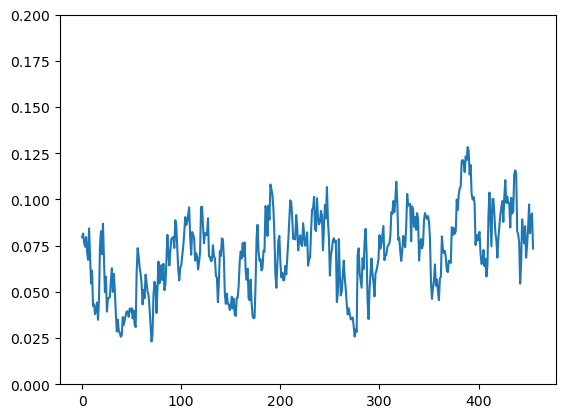

In [9]:
import matplotlib.pyplot as plt

plt.plot(ds.headers['ATMOS_R0']) 
#some times have bad seeing
plt.ylim(0, .2)
plt.show()

## Downloading FITS Data for the VBI series
This section assumes you have running Globus Connect Personal. You will need to do this to download FITS data to your machines. See the [Downloading Data](https://docs.dkist.nso.edu/projects/python-tools/en/stable/tutorial/5_downloading_data.html) section of the User Tools documentation to understand what you need to do. 

We now download the whole dataset on the local disk

In [10]:
## These we have already. Repeated here just for clarity
#res = Fido.search(a.dkist.Dataset("ARNNW"))
#asdf_file = Fido.fetch(res, path="~/DKIST/workshops/SPD_2025/{instrument}/{dataset_id}/")

# We now get the VBI series
ds = dkist.load_dataset(asdf_file)
ds.files.download()

INFO: Refreshing dataset inventory for dataset ARNNW [dkist.io.file_manager]


|                                                                                                             …

PENDING: Starting Transfer
Task completed with SUCCEEDED status.


In [8]:
ds.data

dask.array<reshape, shape=(456, 4096, 4096), dtype=float32, chunksize=(1, 4096, 4096), chunktype=numpy.ndarray>

And if we plot an image (#200 in the series):

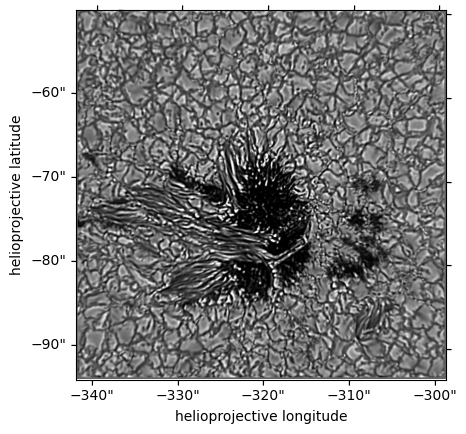

In [22]:
#ds[200,500:2501,500:2501].plot(cmap="gray",vmax=95000,vmin=10000)
ds[200].plot(cmap="gray",vmax=95000,vmin=10000)
plt.show()

Just as a reminder, the spatial coordinates can be a few arcsec off for a variety of reasons - no attempt has been made at correlation with full disk data (e.g. from SDO). Also, note that data values for VBI L1 data are not in any physical units at this moment. 

## Displaying the series of images

Next we create a dataCube of the sequence (only 100 of the 456 images, for speeding up things), and prepare a movie for a sub-portion of the FOV. From the plot of R0 above, we can chose a stretch of good seeing - the time 300-400 will be good. Or, to better display the seeing effects, the times 100-200.

In [10]:
from astropy.io import fits
import numpy as np

#create fits cube. 100 times, 2000 x 2000 pixels

dataCube=[]
#loc_files=ds.files.filenames[300:400] #these times are actually pretty good! Let's try another
loc_files=ds.files.filenames[100:200] 

for i in range(len(loc_files)):
   dataCube.append(fits.open("./VBI/ARNNW/"+loc_files[i])[1].data[0,500:2501,500:2501]) 
dataCube=np.asarray(dataCube)

#save pre-destretch data cube of 100 (sub-)frames
fits.writeto("./VBI/ARNNW/results/pre-destretch_dataCube.fits",dataCube,overwrite=True)

In [21]:
import utilvbi # to make a movie

#import importlib
#importlib.reload(utilvbi) # might need to re-import it if you change something


from astropy.io import fits
import numpy as np

#restore datacube
dataCube=fits.open("./VBI/ARNNW/results/pre-destretch_dataCube.fits")[0].data


#make the movie 
utilvbi.storeSequence(dataCube,"./VBI/ARNNW/results/pre-destretch_short.bluecont.mp4", dpi=500, write=True)

When playing this movie one can notice a "image wobble" with some more global and some locally shifted subfields. 

In [27]:
#cell commented to avoid large volume file for GitHub upload

#from IPython.display import Video
#Video("./VBI/ARNNW/results/pre-destretch_short.bluecont.mp4", embed=True, width=800, height=800)

## Running the destretching code

Since each VBI image is speckle-reconstructed independently from one other, small distortions will still appear in the sequence of images, especially towards the edges of the field of view (away from the lock point of AO), and/or in times when the seeing is not as good. The removal of these residual artifacts is often referred to as "destretching", and is performed by cross-correlating small patches of the field of view in time, while allowing (hopefully) for the evolution of the solar scene. 

No destretching is performed in the VBI L1 pipeline; we will use here a postprocessing destretch code written by Friedrich Woeger and made available at: https://bitbucket.org/dkist-community-code/destretch/src/main/.  Note that this code is not yet an official DKIST tool release, and is open for improvement by users. Please contact F. Woeger (fwoeger@nso.edu) for suggestions.

#### Parameters
tileSizeInput: this sets the subfield sizes used for the subfield crosscorrelation. In the example below we chose four sizes, from 128 to 24 (pixels), to be used sequentially 

rMean: this is used to detrend the shift vectors by creating a running mean over the input cube as reference.

globalTrack: (optional) aligns the full images on top of each other (coarse alignment). Format requested for the globalTrack vector: [lowerY, lowerX, fieldSize] (in pixels). In the example below, a sub region of 256 pixels (~2-3") starting from x=y =1500

#### Syntax: 
destretchedDataCube = destretchSeq(dataCube, tileSizeInput, rMean=3, globalTrack = [1500,1500,256])

### This might take a while to run.

Be aware that the code will run several times (depending on the size vector specified) with the output message: "Image X of 100...". Please check if the fits file "./results/postdestretch_dataCube.fits" has been created before moving on and the in-process star for the cell has changed to a number.


In [11]:
import destretch as destr
from astropy.io import fits
import numpy as np

#restore datacube
dataCube=fits.open("./VBI/ARNNW/results/pre-destretch_dataCube.fits")[0].data

#destretch
tileSizeInput = [128, 64, 48, 24]  
dataCubeTracked = destr.destretchSeq(dataCube, tileSizeInput, rMean=3, globalTrack=None) 
#save as Tracked datacube 
fits.writeto("./VBI/ARNNW/results//postdestretch_dataCube.fits",dataCubeTracked,overwrite=True)

Image 100 of 100 ...  

In [68]:
#make the new video

#restore tracked datacube
dataCubeTracked=fits.open("./VBI/ARNNW/results/postdestretch_dataCube.fits")[0].data

utilvbi.storeSequence(dataCubeTracked,"./VBI/ARNNW/results/postdestretch_short.bluecont.mp4", dpi=500, write=True)

2025-06-10 08:59:50 - matplotlib.animation - INFO: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-06-10 08:59:50 - matplotlib.animation - INFO: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 3200x2400 -pix_fmt rgba -framerate 10 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ./VBI/ARNNW/results/postdestretch_short.bluecont.mp4


In [25]:
# THIS CELL NEEDS TO RUN TO SHOW FINAL RESULTS. Deleted because GitHub would not load the big file

#from IPython.display import Video
#Video("./VBI/ARNNW/results/postdestretch_short.bluecont.mp4", embed=True, width=800, height=800)

## Intensity normalization 

You may notice that the video flickers in intensity. This might be due to various reason, from the Sun rising in the sky in the morning, to thin clouds passing, to the effect of speckle reconstruction. It might however be advantageous for your analysis to have a normalized intensity series. The easiest way is to find a patch of quiet Sun, and normalize each frame to the average intensity of that patch. 

Or, in a bit more sophisticated way, one can perform a so-called "histogram matching", available in the skimage package.  Let's pick the first frame as a reference frame:

In [14]:
import astropy.io.fits as pf
import skimage
from skimage.exposure import match_histograms

import utilvbi
from IPython.display import Video

#restore tracked datacube
dataCubeTracked=fits.open("./VBI/ARNNW/results/postdestretch_dataCube.fits")[0].data

gbref=dataCubeTracked[0,:,:] #choosing here the first image as a reference
timegb,yy,xx=dataCubeTracked.shape
   
dataCubeTrackedhist=[]
for idata in range(timegb):
 image=dataCubeTracked[idata,:,:]
 matched = match_histograms(image, gbref)
 dataCubeTrackedhist.append(matched)
   
dataCubeTrackedhist=np.asarray(dataCubeTrackedhist)
    
#save result and movie  
fits.writeto("./VBI/ARNNW/results/postdestretch_histomatch_dataCube.fits",dataCubeTrackedhist,overwrite=True)#save movie


2025-06-05 18:43:55 - matplotlib.animation - INFO: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-06-05 18:43:55 - matplotlib.animation - INFO: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1920x1440 -pix_fmt rgba -framerate 10 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ./VBI/ARNNW/results/postdestretch_histomatch_short.bluecont.mp4


In [40]:
utilvbi.storeSequence(dataCubeTrackedhist,"./VBI/ARNNW/results/postdestretch_histomatch_short.bluecont.mp4", dpi=300, write=True)

2025-06-06 15:10:33 - matplotlib.animation - INFO: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-06-06 15:10:33 - matplotlib.animation - INFO: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1920x1440 -pix_fmt rgba -framerate 10 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ./VBI/ARNNW/results/postdestretch_histomatch_short.bluecont.mp4


In [16]:
# As before, this cell is commenetd because GitHub would not load a large file

#from IPython.display import Video
#Video("./VBI/ARNNW/results/postdestretch_histomatch_short.bluecont.mp4", embed=True, width=800, height=800)